# Implement jump in response to object detection

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from gymnasium import spaces

from flygym import Fly, SingleFlySimulation, Camera

from flygym.examples.common import PreprogrammedSteps
from flygym.arena import BaseArena
from flygym import preprogrammed
import dm_control.mjcf as mjcf
from flygym.vision import save_video_with_vision_insets
from typing import Union, Tuple, List, Optional
from IPython.display import Video
from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)


In [12]:

class VisionSimulation(SingleFlySimulation):
    def __init__(
        self, camera: Camera, obj_threshold=0.15, decision_interval=0.05, **kwargs
    ):
        super().__init__(cameras=[camera], **kwargs)

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.fly.retina.num_ommatidia_per_eye, 2))
        for i in range(self.fly.retina.num_ommatidia_per_eye):
            mask = self.fly.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        self.observation_space = spaces.Box(0, 1, shape=(6,))

    def step(self, action):
        raw_obs, _, _, _, info = super().step(action)
        render_res = super().render()[0]
        if render_res is not None:
            # record visual inputs too because they will be played in the video
            self.visual_inputs_hist.append(raw_obs["vision"].copy())
            
        visual_features = self._process_visual_observation(raw_obs["vision"])
        return visual_features, 0, False, False, {}

    def _process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= self.fly.retina.nrows  # normalize y_center
        features[:, 1] /= self.fly.retina.ncols  # normalize x_center
        features[:, 2] /= self.fly.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel().astype("float32")

    def reset(self, seed=0, **kwargs):
        raw_obs, _ = super().reset(seed=seed)
        self.visual_inputs_hist = []
        return self._process_visual_observation(raw_obs["vision"]), {}


class MovingObjArena(BaseArena):
    def __init__(
        self,
        size=(300, 300),
        friction=(1, 0.005, 0.0001),
        obj_radius=1,
        init_ball_pos=(12, 0),
        move_speed=15,
        move_direction="right",
    ):
        self.ball_positions = []

        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()
        

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),     
            fovy=45,
        )
        self.birdeye_cam_zoom = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_zoom",
            mode="fixed",
            pos=(15, 0, 20),
            euler=(0, 0, 0),
            fovy=45,
        )

        self.tenta = self.root_element.worldbody.add(
            "camera",
            name="tenta",
            mode="fixed",
            pos=(2, -18, 9),
            euler=(np.deg2rad(65), 0, 0),
            fovy=45,
        )

    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle

    def step(self, dt, physics):
        ball_x, ball_y = self.ball_pos[:2]
        self.ball_positions.append((ball_x, ball_y))
        # Direct the movement strictly along the x-axis
        heading_vec = np.array([-1, 0])  # Change direction vector to move left
        self.ball_pos[:2] += self.move_speed * heading_vec * dt # Update x position
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos


In [13]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]


fly = Fly(
    contact_sensor_placements=contact_sensor_placements,
    enable_vision=True,
    render_raw_vision=True,
    enable_adhesion =True,
    draw_adhesion=True
)

arena=MovingObjArena()

cam1= Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800,608)
)

cam3=Camera(
    fly=fly,
    camera_id="tenta",
    play_speed=0.2,
    window_size=(800, 608),
)

sim = VisionSimulation(fly=fly, camera=cam3, arena=arena)

In [41]:
preprogrammed_steps = PreprogrammedSteps()
swing_periods = preprogrammed_steps.swing_period
legs = preprogrammed_steps.legs

adhesion_action= np.zeros(len(legs))
# Initialize standing action using preprogrammed steps for all legs
standing_action = []
for leg in legs:
    standing_action.extend(
        preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1])
    )

print(standing_action[fly.actuated_joints.index("joint_LHCoxa")],)
stand_action = {"joints": standing_action, "adhesion": adhesion_action}

timestep = sim.timestep
obj_threshold = 0.3
detect_object=[]

# Let the fly stand on the floor first
for i in range(int(0.2 // timestep)):
    detect_object.append(obs[2])
    obs, reward, terminated, truncated, info =sim.step(stand_action)

run_time1 =0.2
run_time2 =0.5

# Simulation parameters
target_num_steps1 = int(run_time1 / timestep)
target_num_steps2 = int(run_time2 / timestep)

# Define group actions for the specific joints
group_action = {
    "joint_LMTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_LMTibia")], 2.60, target_num_steps1),
    "joint_RMTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_RMTibia")], 2.60, target_num_steps1),
    "joint_LMTarsus1": np.linspace(standing_action[fly.actuated_joints.index("joint_LMTarsus1")], -1.6, target_num_steps1),
    "joint_RMTarsus1": np.linspace(standing_action[fly.actuated_joints.index("joint_RMTarsus1")], -1.6, target_num_steps1),
    "joint_LHTarsus1": np.linspace(standing_action[fly.actuated_joints.index("joint_LHTarsus1")], -1, target_num_steps1),
    "joint_RHTarsus1": np.linspace(standing_action[fly.actuated_joints.index("joint_RHTarsus1")], -1, target_num_steps1),
    "joint_LHCoxa": np.linspace(standing_action[fly.actuated_joints.index("joint_LHCoxa")], 0.2, target_num_steps1),
    "joint_RHCoxa": np.linspace(standing_action[fly.actuated_joints.index("joint_RHCoxa")], 0.2, target_num_steps1),
    "joint_LHTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_LHTibia")], standing_action[fly.actuated_joints.index("joint_LHTibia")], target_num_steps1),
    "joint_RHTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_RHTibia")], standing_action[fly.actuated_joints.index("joint_RHTibia")], target_num_steps1)
}

#define the action for the jump
jumps_action = {
    "joint_LMTibia": np.linspace(2.60, 0, target_num_steps2),
    "joint_RMTibia": np.linspace(2.60, 0, target_num_steps2),
    "joint_LMTarsus1": np.linspace(-1.6, 0, target_num_steps2),
    "joint_RMTarsus1": np.linspace(-1.6, 0, target_num_steps2),
    "joint_LHTarsus1": np.linspace(-1, 0, target_num_steps2),
    "joint_RHTarsus1": np.linspace(-1, 0, target_num_steps2),
    "joint_LHCoxa": np.linspace(0.2, 0, target_num_steps2),
    "joint_RHCoxa": np.linspace(0.2, 0, target_num_steps2),
    "joint_LHTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_LHTibia")], 1.5,target_num_steps2),
    "joint_RHTibia": np.linspace(standing_action[fly.actuated_joints.index("joint_RHTibia")], 1.5,target_num_steps2)

}

# Actuated joints and data block initialization
actuated_joints = ["joint_LMTibia", "joint_RMTibia", "joint_LMTarsus1", "joint_RMTarsus1" ,"joint_LHTarsus1", "joint_RHTarsus1","joint_LHCoxa", "joint_RHCoxa", "joint_LHTibia", "joint_RHTibia"]
data_block1 = np.zeros((len(actuated_joints), target_num_steps1))
output_t1 = np.arange(target_num_steps1) * timestep
input_t1 = np.linspace(0, timestep * (target_num_steps1 - 1), num=target_num_steps1)

data_block2 = np.zeros((len(actuated_joints), target_num_steps2))
output_t2 = np.arange(target_num_steps2) * timestep
input_t2 = np.linspace(0, timestep * (target_num_steps2 - 1), num=target_num_steps2)


# Interpolation for the specified joints
for i, joint in enumerate(actuated_joints):
    data_block1[i, :] = np.interp(output_t1, input_t1, np.array(group_action[joint]))

for i, joint in enumerate(actuated_joints):
    data_block2[i, :] = np.interp(output_t2, input_t2, np.array(jumps_action[joint]))


# Get the total number of actuated joints
total_actuated_joints = len(fly.actuated_joints)

# Lists to store joint angle values for plotting
joint_LMTibia_values = []
joint_RMTibia_values = []
joint_LMTarsus_values = []
joint_RMTarsus_values = []
joint_LHTarsus_values = []
joint_RHTarsus_values = []
joint_LHCoxa_values = []
joint_RHCoxa_values = []


joint_angles=standing_action.copy()
wait=standing_action.copy()

for i in range(target_num_steps1):
    detect_object.append(obs[2])
    
    # Update specific joints with interpolated values
    joint_angles[fly.actuated_joints.index("joint_LMTibia")] = data_block1[0, i]
    joint_angles[fly.actuated_joints.index("joint_RMTibia")] = data_block1[1, i]
    joint_angles[fly.actuated_joints.index("joint_LMTarsus1")] = data_block1[2, i]
    joint_angles[fly.actuated_joints.index("joint_RMTarsus1")] = data_block1[3, i]
    joint_angles[fly.actuated_joints.index("joint_LHTarsus1")] = data_block1[4, i]
    joint_angles[fly.actuated_joints.index("joint_RHTarsus1")] = data_block1[5, i]    
    joint_angles[fly.actuated_joints.index("joint_LHCoxa")] = data_block1[6, i]
    joint_angles[fly.actuated_joints.index("joint_RHCoxa")] = data_block1[7, i]

        # Store values for plotting
    joint_LMTibia_values.append(data_block1[0, i])
    joint_RMTibia_values.append(data_block1[1, i])
    joint_LMTarsus_values.append(data_block1[2, i])
    joint_RMTarsus_values.append(data_block1[3, i])
    joint_LHTarsus_values.append(data_block1[4, i])
    joint_RHTarsus_values.append(data_block1[5, i])
    joint_LHCoxa_values.append(data_block1[6, i])
    joint_RHCoxa_values.append(data_block1[7, i])

    action = {"joints": joint_angles, "adhesion": adhesion_action}

    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()


for i in range (target_num_steps2):
    detect_object.append(obs[2])
    if obs[2] > obj_threshold:
        if i < (target_num_steps2 - 3000):
            adhesion_action = np.ones(len(legs))
        else:
            adhesion_action = np.zeros(len(legs))
        
        joint_angles[fly.actuated_joints.index("joint_LMTibia")] = data_block2[0, i]
        joint_angles[fly.actuated_joints.index("joint_RMTibia")] = data_block2[1, i]
        joint_angles[fly.actuated_joints.index("joint_LMTarsus1")] = data_block2[2, i]
        joint_angles[fly.actuated_joints.index("joint_RMTarsus1")] = data_block2[3, i]
        joint_angles[fly.actuated_joints.index("joint_LHTarsus1")] = data_block2[4, i]
        joint_angles[fly.actuated_joints.index("joint_RHTarsus1")] = data_block2[5, i]   
        joint_angles[fly.actuated_joints.index("joint_LHCoxa")] = data_block2[6, i]
        joint_angles[fly.actuated_joints.index("joint_RHCoxa")] = data_block2[7, i]

        # Store values for plotting
        joint_LMTibia_values.append(data_block2[0, i])
        joint_RMTibia_values.append(data_block2[1, i])
        joint_LMTarsus_values.append(data_block2[2, i])
        joint_RMTarsus_values.append(data_block2[3, i])
        joint_LHTarsus_values.append(data_block2[4, i])
        joint_RHTarsus_values.append(data_block2[5, i])
        joint_LHCoxa_values.append(data_block2[6, i])
        joint_RHCoxa_values.append(data_block2[7, i])

        action = {"joints": joint_angles, "adhesion": adhesion_action}

        obs, reward, terminated, truncated, info =sim.step(action)
        sim.render()
    else: 
        action = {"joints": wait, "adhesion": np.zeros(len(legs))}
        obs, reward, terminated, truncated, info = sim.step(action)
        sim.render()

cam3.save_video('outputs/jump_object_detect.mp4')

Video('outputs/jump_object_detect.mp4', width=800, height=608)



0.37979870389165027
0
0.49514562
1
0.49514562
2
0.49514562
3
0.49514562
4
0.49514562
5
0.49514562
6
0.49514562
7
0.49514562
8
0.49514562
9
0.49514562
10
0.49514562
11
0.49514562
12
0.49514562
13
0.49514562
14
0.49514562
15
0.49514562
16
0.49514562
17
0.49514562
18
0.49514562
19
0.49514562
20
0.49514562
21
0.49514562
22
0.49514562
23
0.49514562
24
0.49514562
25
0.49514562
26
0.49514562
27
0.49514562
28
0.49514562
29
0.49514562
30
0.49514562
31
0.49514562
32
0.49514562
33
0.49514562
34
0.49514562
35
0.49514562
36
0.49514562
37
0.49514562
38
0.49514562
39
0.49514562
40
0.49514562
41
0.49375868
42
0.49375868
43
0.49375868
44
0.49375868
45
0.49375868
46
0.49375868
47
0.49375868
48
0.49375868
49
0.49375868
50
0.49375868
51
0.49375868
52
0.49375868
53
0.49375868
54
0.49375868
55
0.49375868
56
0.49375868
57
0.49375868
58
0.49375868
59
0.49375868
60
0.49375868
61
0.49375868
62
0.49375868
63
0.49375868
64
0.49375868
65
0.49375868
66
0.49375868
67
0.49375868
68
0.49375868
69
0.49375868
70
0.49375

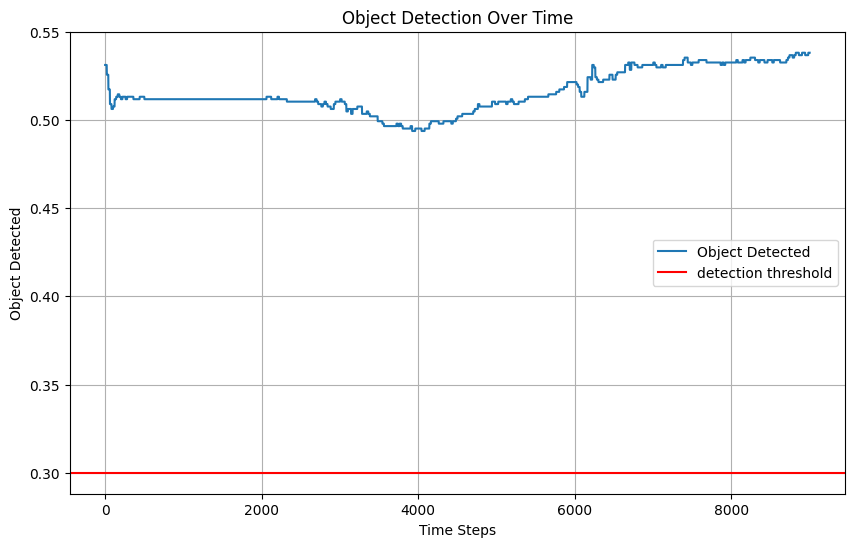

In [43]:
detect_object = np.array(detect_object)
print(detect_object)

plt.figure(figsize=(10, 6))
plt.plot(detect_object, label='Object Detected')
plt.axhline(y=0.3, color='r', linestyle='-', label= 'detection threshold')
#plt.plot(times, fly_x, label='fly position' )
plt.title('Object Detection Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Object Detected')
plt.legend()
plt.grid(True)
plt.show()
